In [1]:
# Plots of circular colonies

In [2]:
!pwd
!date

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/FigureHeight
Wed May 18 11:19:30 PDT 2022


In [3]:
import os
import sys
import importlib
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy import stats as spstats
from aicscytoparam import cytoparam
from scipy import cluster as spcluster
from matplotlib import lines as pltlines
from aicsimageio import AICSImage, writers
from cvapipe_analysis.tools import io, viz, general, controller, shapespace, plotting

sys.path.insert(1, '../tools')
import common

In [4]:
path_config = Path("/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/")
control = controller.Controller(general.load_config_file(path_config))
device = io.LocalStagingIO(control)
df = device.load_step_manifest("preprocessing")
print(df.shape, control.get_staging())

(202847, 1290) /allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_variance


In [5]:
space = shapespace.ShapeSpace(control)
space.execute(df)

In [23]:
def prepare_dataframe_for_colony_analysis(df_input, cvar, unit=0.108, nbins=8, filters_in={}, filters_out={}):
    
    nsamples = df_input.shape[0]
    
    # Getting rid of bad segmented colonies
    df_valid = df_input.copy()

    # Create colony diameter from area
    if "meta_colony_diameter" not in df_valid.columns:
        df_valid['meta_colony_diameter'] = 2*np.sqrt(df_valid['meta_colony_area']/np.pi)
    
    df_valid = df_valid.loc[
        (df_valid.meta_fov_outside_overview == False)&
        (df_valid.meta_plate_bad_segmentation == False)&
#         (df_valid.meta_colony_touching_boundary==False)&
        (df_valid.meta_colony_area.isna() == False)]
    
    print(df_valid.shape, "Colony diam:", np.percentile(df_valid['meta_colony_diameter'].values, [5,50,95]))

    vmin = 1.08*4*df_valid.meta_colony_diameter.values.min()
    vmax = 1.08*4*df_valid.meta_colony_diameter.values.max()
    pcts = np.percentile(1.08*4*df_valid.meta_colony_diameter.values,np.linspace(0,100,nbins+1))
    
    for f, values in filters_in.items():
        df_valid = df_valid.loc[df_valid[f].isin(values)]

    for f, values in filters_out.items():
        df_valid = df_valid.loc[~df_valid[f].isin(values)]
    
    if df_valid.shape[0] == 0:
        raise ValueError('No cells found for the current selection')
    
    # Prepare dataframe for analysis
    df = df_valid[['FOVId','meta_colony_diameter',cvar,'meta_fov_edgedist','structure_name']].copy()
    
    # Colony diameter in microns
    df['meta_colony_diameter'] = 1.08 * 4 * df['meta_colony_diameter']
    df['meta_colony_radius'] = 0.5 * df['meta_colony_diameter']
    df = df.loc[df.meta_fov_edgedist<df.meta_colony_radius]
    df['color'] = unit * df[cvar]
    df['meta_fov_normdist'] = 1 - df['meta_fov_edgedist']/df['meta_colony_radius']
    df['meta_fov_theta'] = 2*np.pi*np.random.rand(df.shape[0])
    
    for g, (dinf, dsup) in enumerate(zip(pcts[:-1],pcts[1:])):

        indexes = df.loc[
            (df.meta_colony_diameter>(dinf if g else 0))&
            (df.meta_colony_diameter<=dsup)].index

        df.loc[indexes,'group'] = g
        df.loc[indexes,'meta_colony_avg_radius'] = df.loc[indexes,'meta_colony_radius'].mean()

    df['meta_fov_radius'] = df.meta_colony_avg_radius*df.meta_fov_normdist
    df['meta_fov_x'] = df.meta_fov_radius*np.cos(df.meta_fov_theta)
    df['meta_fov_y'] = df.meta_fov_radius*np.sin(df.meta_fov_theta)

#     df = df.drop(columns=['meta_fov_theta','meta_fov_edgedist','meta_colony_radius'])

    df = df.sort_values('color')

    df = df.astype({"group": "int64"})
    
    print(f'Number of input samples: {nsamples}')
    print(f'Number of used for the plot: {df.shape[0]}')
    print(f'Proportion of samples kept: {(100*df.shape[0]/nsamples):.1f}%')
    
    return df, pcts, df_valid

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def plot_template_colonies(df_input, pcts, vmin=None, vmax=None, clip=0, cmap='jet', force_symmetry=False, save=None):

    df = df_input.copy()
    print(df.shape)
    df = df.dropna(subset=["color"])
    print(df.shape)
    
    if clip:
        cinf, csup = np.percentile(df['color'], [clip,100-clip])
        df['color'] = np.clip(df['color'], cinf, csup)

    nbins = len(pcts)-1
    hmin = df['color'].min() if vmin is None else vmin
    hmax = df['color'].max() if vmax is None else vmax

    if force_symmetry:
        hmag = np.max([abs(hmin),hmax])
        hmin = -hmag
        hmax = hmag

    print('Min and max value for colors:',hmin, hmax)

    fig, axs = plt.subplots(2,nbins,
        figsize = (6*nbins,9),
        sharey = 'row',
        sharex = 'col',
        gridspec_kw={'wspace': 0.0, 'hspace': 0.25, 'height_ratios': [3, 1]}
    )

    for g, df_group in df.groupby('group'):
        
        frac = 100*df_group.shape[0] / df.shape[0]
        radius = df_group.meta_colony_avg_radius[df_group.index[0]]
        area_inf = 1e-3*(np.pi*(0.5*pcts[g+0])**2)
        area_sup = 1e-3*(np.pi*(0.5*pcts[g+1])**2)
        area_avg = 1e-3*(np.pi*(radius**2))
        color_avg = df_group['color'].values.mean()
        axs[0,g].set_title(
            f'{area_inf:.0f}k $\mu m^2$ - {area_sup:.0f}k $\mu m^2$\n{area_avg:.0f}k $\mu m^2$ ({frac:.0f}%, µ~{color_avg:.1f})', fontsize=18)
        circle = plt.Circle((0, 0), radius, color='k', fill=False)
        axs[0,g].add_patch(circle)
        axs[0,g].axis('off')

        # 1st plot (randomize the points first)
        x = df_group.meta_fov_x.values
        y = df_group.meta_fov_y.values
        z = df_group['color'].values
        order = np.random.rand(x.size).argsort()
        x = x[order]
        y = y[order]
        z = z[order]
        axs[0,g].scatter(
            x,
            y,
            s = 1,
            c = z,
            cmap = cmap,
            vmin = hmin,
            vmax = hmax
        )

        # 2nd plot
        x = df_group.meta_fov_radius.values
        y = df_group['color'].values
        axs[1,g].scatter( x, y, s=1, c='k', alpha=0.1)
        axs[1,g].scatter(-x, y, s=1, c='k', alpha=0.1)
        order = x.argsort()
        x = running_mean(x[order], 128)
        y = running_mean(y[order], 128)
        axs[1,g].plot(x,y,color='r')
        axs[1,g].plot(-x,y,color='r')
        axs[1,g].tick_params(axis='both', labelsize=30)

    radius = df.meta_colony_avg_radius.max()

    for ax in range(nbins):
        axs[0,ax].set_xlim(-radius,radius)
        axs[0,ax].set_ylim(-radius,radius)

        axs[1,ax].set_xlim(-radius,radius)
        axs[1,ax].set_ylim(hmin,hmax)
        axs[1,ax].set_xticks([-400, 0, 400])
        
    if save is not None:        
        plt.savefig(save, bbox_inches="tight", format='png', dpi=150)
    plt.show()

(151958, 1299) Colony diam: [ 93.43769881 173.64578572 326.77245052]
Number of input samples: 202847
Number of used for the plot: 151958
Proportion of samples kept: 74.9%
(151958, 14)
(151958, 14)
Min and max value for colors: 3 20


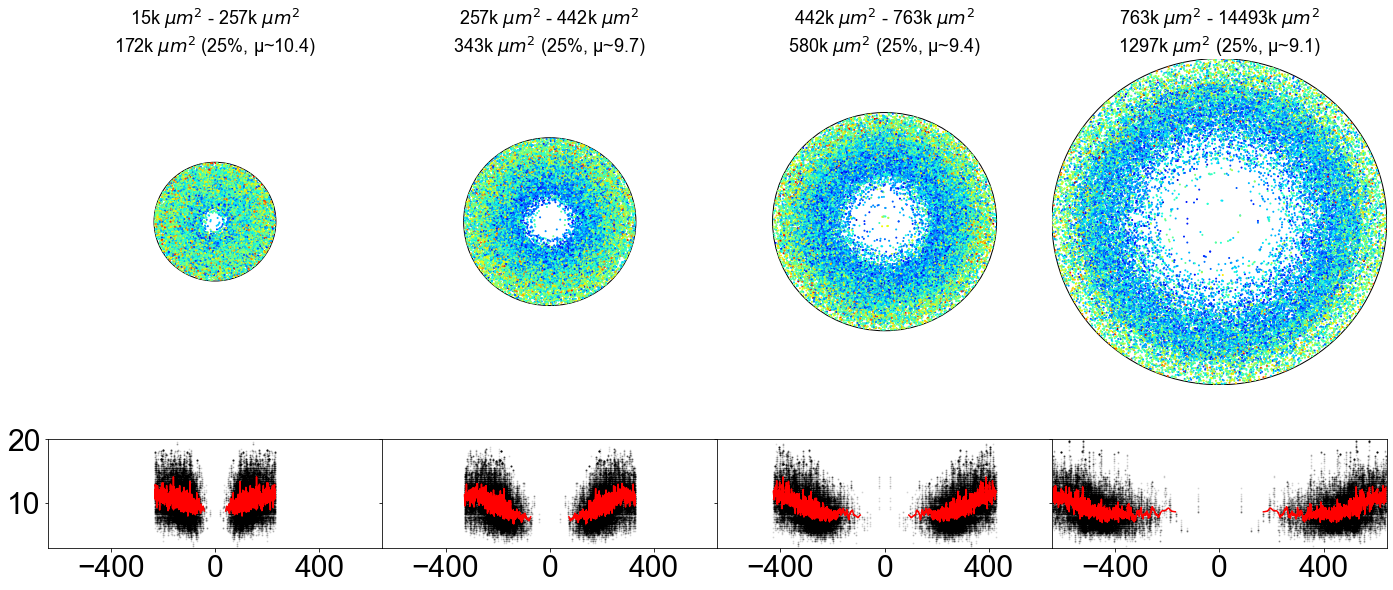

In [24]:
df_colony, pcts, df_filtered = prepare_dataframe_for_colony_analysis(
    df_input = df,
    filters_in = {'meta_imaging_mode': ['Mode A','Mode B','Mode C']},
    cvar = 'MEM_position_depth',
    unit = 0.108,
    nbins = 4
)
plot_template_colonies(
    df_input = df_colony,
    pcts = pcts,
    vmin = 3,
    vmax = 20,
    save = "FigureHeight2_ABC.png"
)

(151958, 1299) Colony diam: [ 93.43769881 173.64578572 326.77245052]
Number of input samples: 202847
Number of used for the plot: 112037
Proportion of samples kept: 55.2%
(112037, 14)
(112037, 14)
Min and max value for colors: 3 20


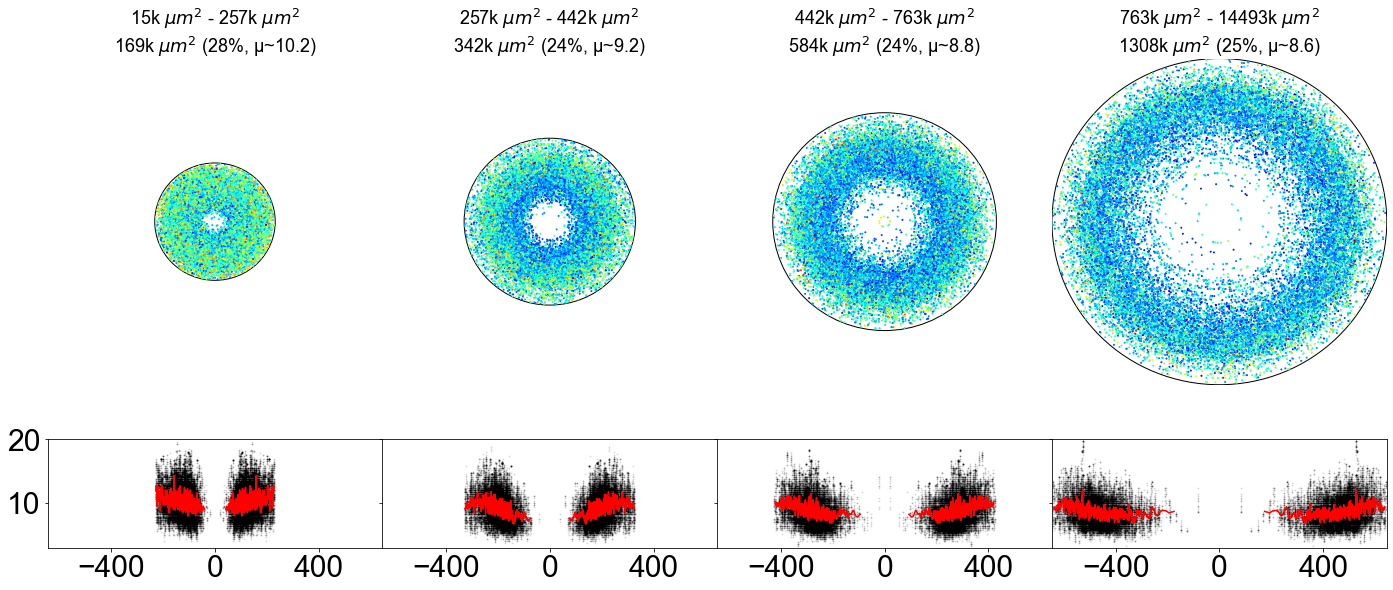

In [25]:
df_colony, pcts, df_filtered = prepare_dataframe_for_colony_analysis(
    df_input = df,
    filters_in = {'meta_imaging_mode': ['Mode A','Mode B']},
    cvar = 'MEM_position_depth',
    unit = 0.108,
    nbins = 4
)
plot_template_colonies(
    df_input = df_colony,
    pcts = pcts,
    vmin = 3,
    vmax = 20,
    save = "FigureHeight2_AB.png"
)

(151958, 1299) Colony diam: [ 93.43769881 173.64578572 326.77245052]
Number of input samples: 202847
Number of used for the plot: 39921
Proportion of samples kept: 19.7%
(39921, 14)
(39921, 14)
Min and max value for colors: 3 20


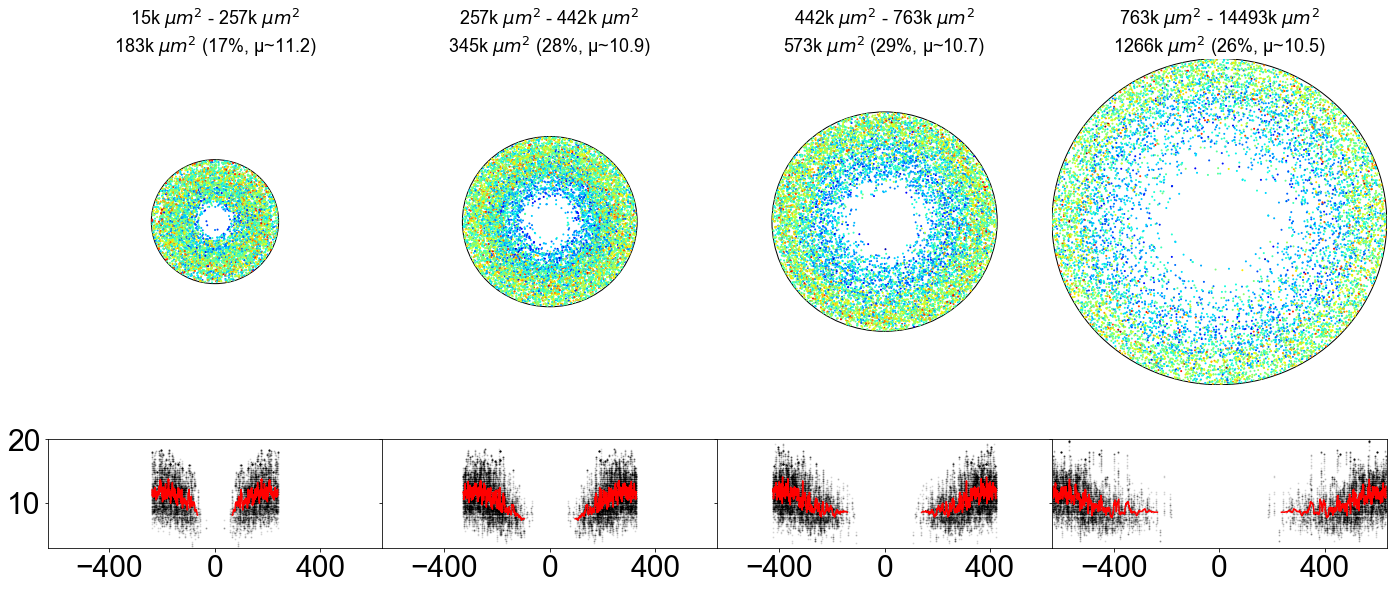

In [26]:
df_colony, pcts, df_filtered = prepare_dataframe_for_colony_analysis(
    df_input = df,
    filters_in = {'meta_imaging_mode': ['Mode C']},
    cvar = 'MEM_position_depth',
    unit = 0.108,
    nbins = 4
)
plot_template_colonies(
    df_input = df_colony,
    pcts = pcts,
    vmin = 3,
    vmax = 20,
    save = "FigureHeight2_C.png"
)

In [27]:
for sm in control.get_shape_modes():
    df.loc[space.shape_modes.index, sm] = space.shape_modes[sm]

(151958, 1299) Colony diam: [ 93.43769881 173.64578572 326.77245052]
Number of input samples: 202847
Number of used for the plot: 151958
Proportion of samples kept: 74.9%
(151958, 14)
(131791, 14)
Min and max value for colors: -19.224285141073373 19.224285141073373


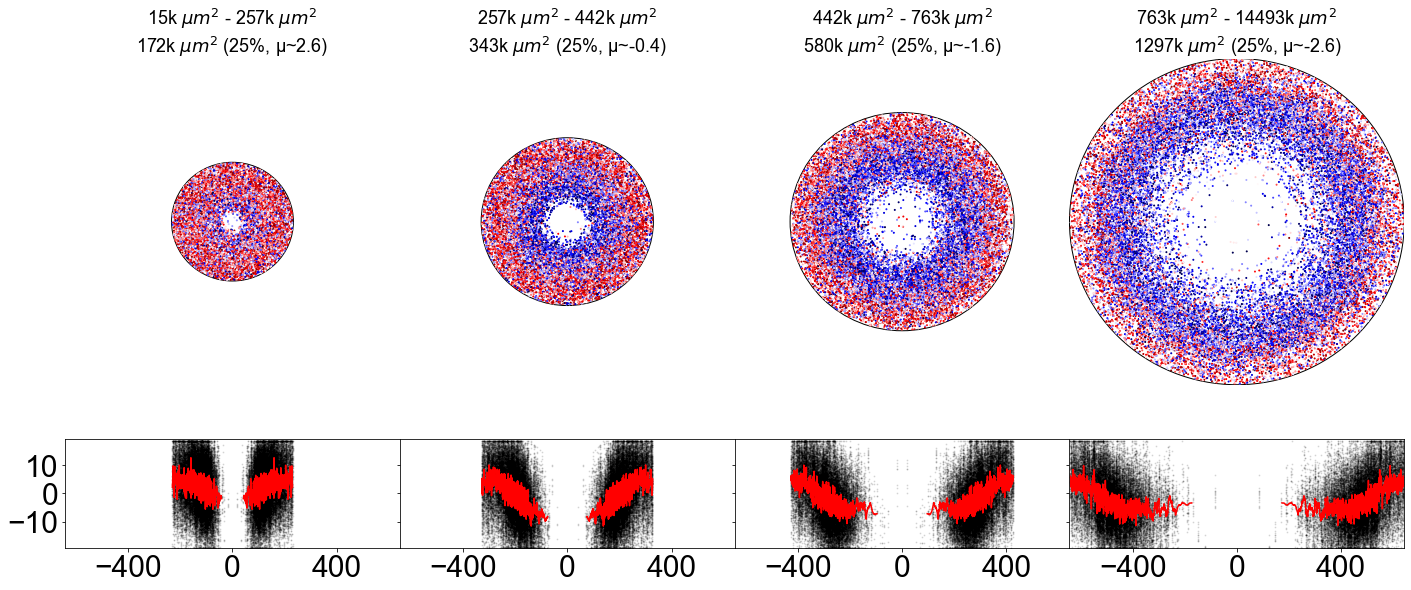

(151958, 1299) Colony diam: [ 93.43769881 173.64578572 326.77245052]
Number of input samples: 202847
Number of used for the plot: 151958
Proportion of samples kept: 74.9%
(151958, 14)
(131791, 14)
Min and max value for colors: -15.827413455470262 15.827413455470262


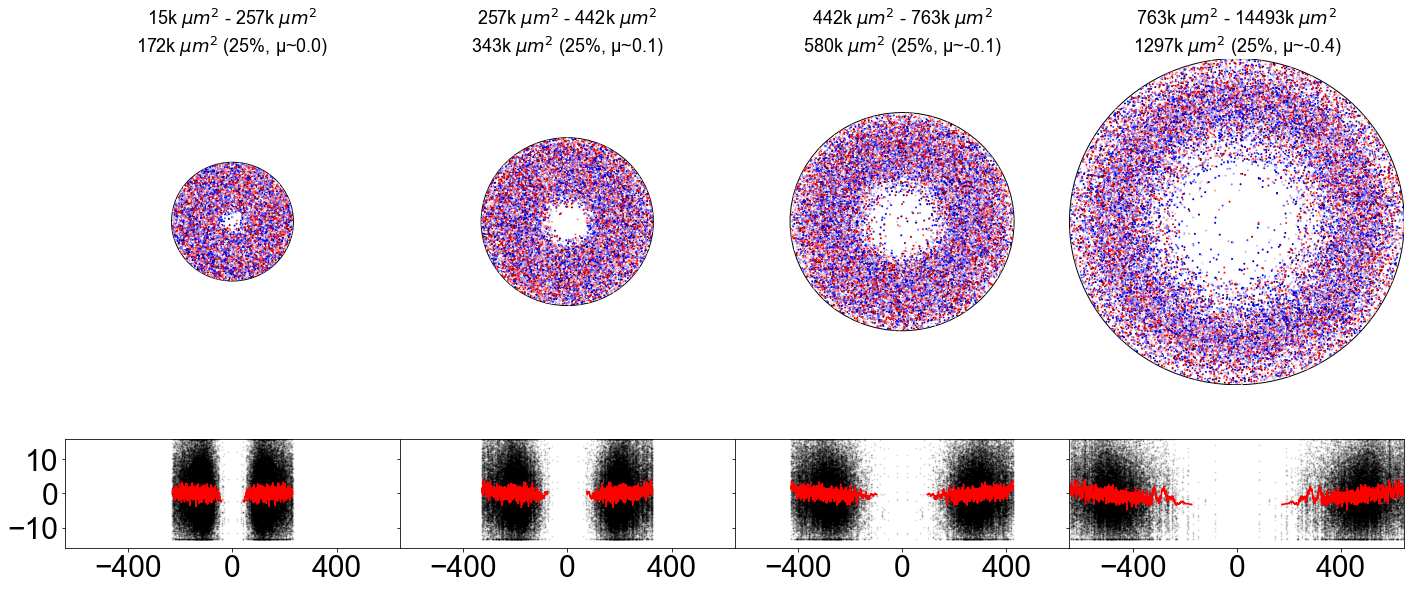

(151958, 1299) Colony diam: [ 93.43769881 173.64578572 326.77245052]
Number of input samples: 202847
Number of used for the plot: 151958
Proportion of samples kept: 74.9%
(151958, 14)
(131791, 14)
Min and max value for colors: -14.056794597593985 14.056794597593985


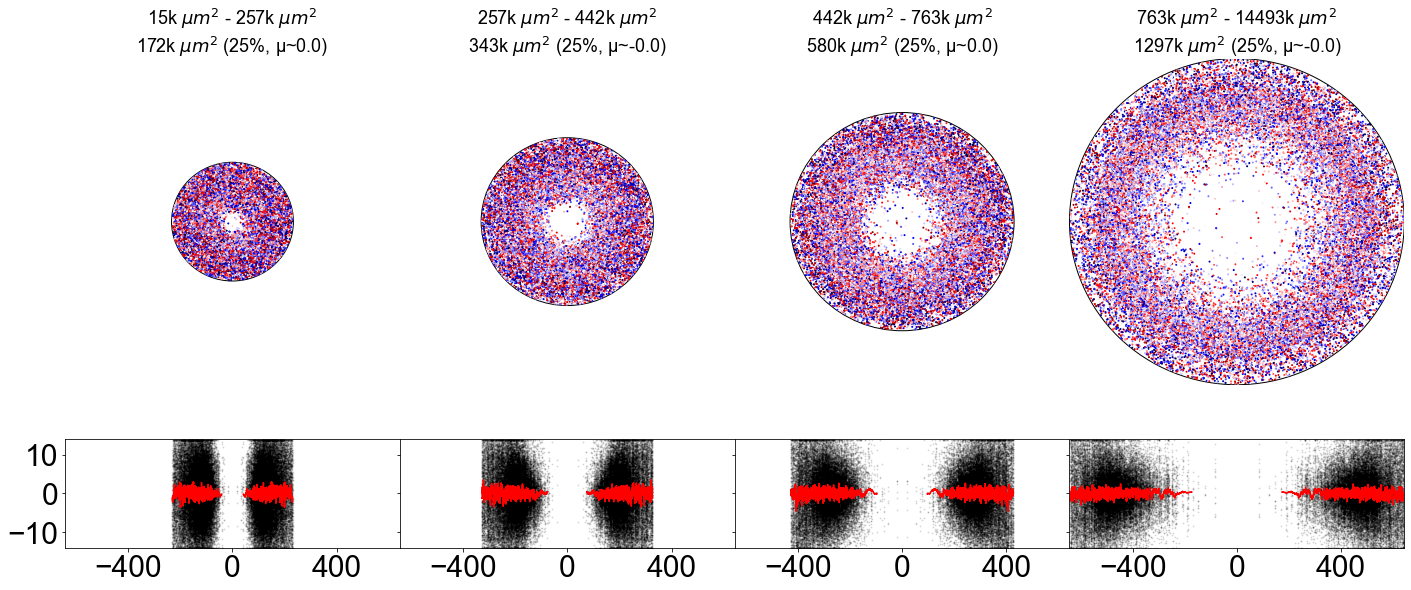

(151958, 1299) Colony diam: [ 93.43769881 173.64578572 326.77245052]
Number of input samples: 202847
Number of used for the plot: 151958
Proportion of samples kept: 74.9%
(151958, 14)
(131791, 14)
Min and max value for colors: -11.371525821348898 11.371525821348898


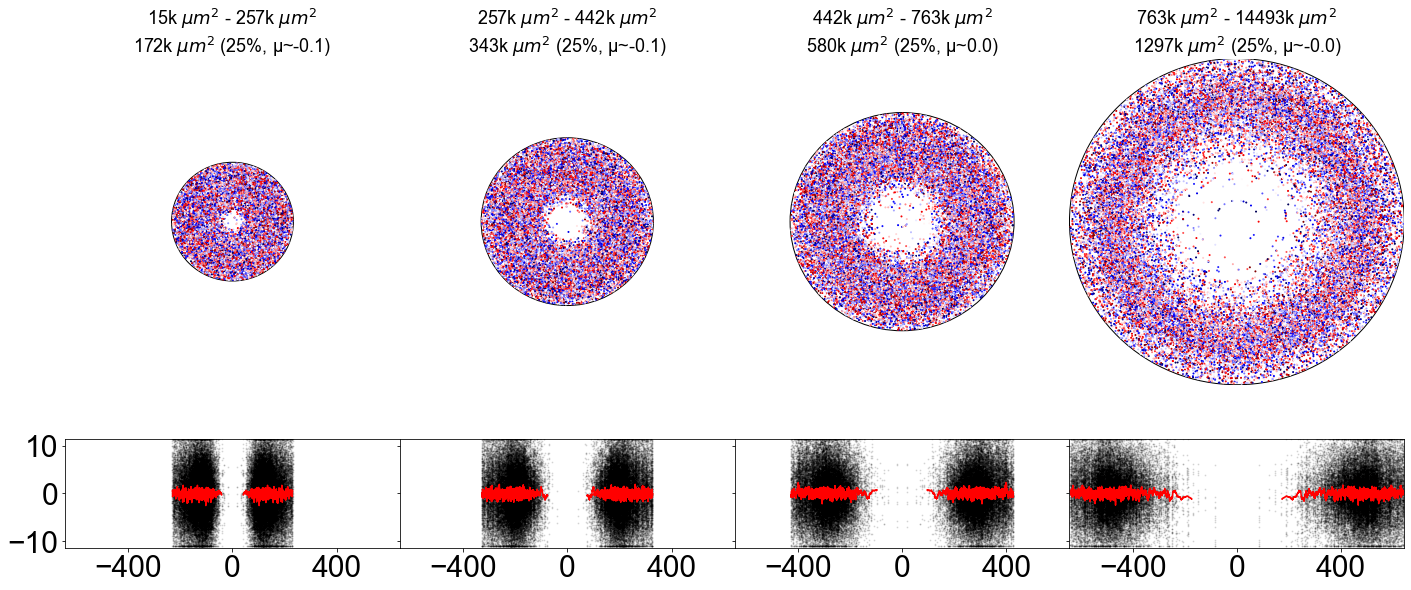

(151958, 1299) Colony diam: [ 93.43769881 173.64578572 326.77245052]
Number of input samples: 202847
Number of used for the plot: 151958
Proportion of samples kept: 74.9%
(151958, 14)
(131791, 14)
Min and max value for colors: -11.75252220681134 11.75252220681134


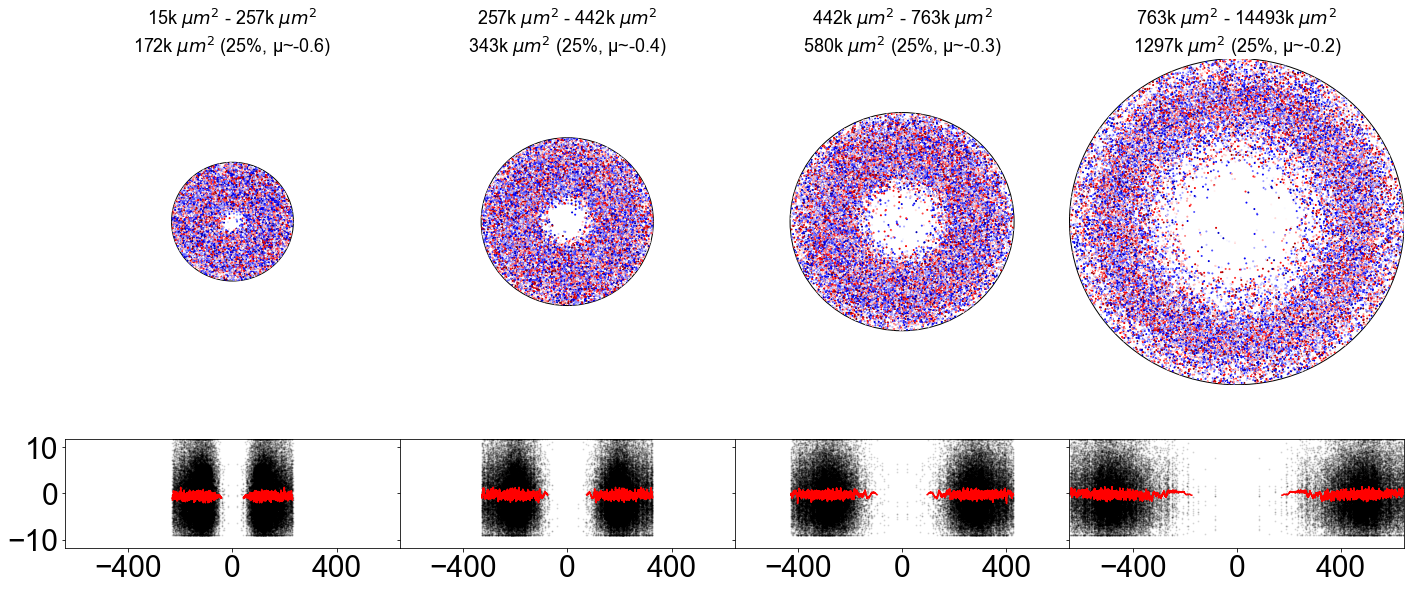

(151958, 1299) Colony diam: [ 93.43769881 173.64578572 326.77245052]
Number of input samples: 202847
Number of used for the plot: 151958
Proportion of samples kept: 74.9%
(151958, 14)
(131791, 14)
Min and max value for colors: -9.20100335824999 9.20100335824999


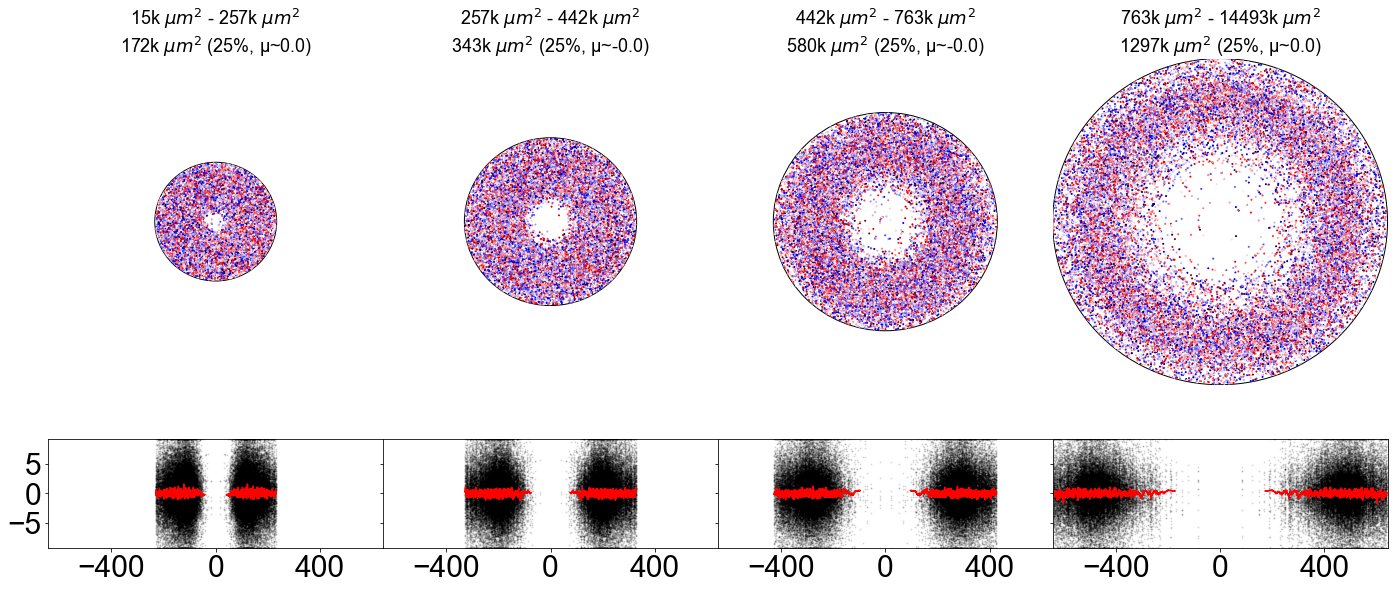

(151958, 1299) Colony diam: [ 93.43769881 173.64578572 326.77245052]
Number of input samples: 202847
Number of used for the plot: 151958
Proportion of samples kept: 74.9%
(151958, 14)
(131791, 14)
Min and max value for colors: -8.73387630772664 8.73387630772664


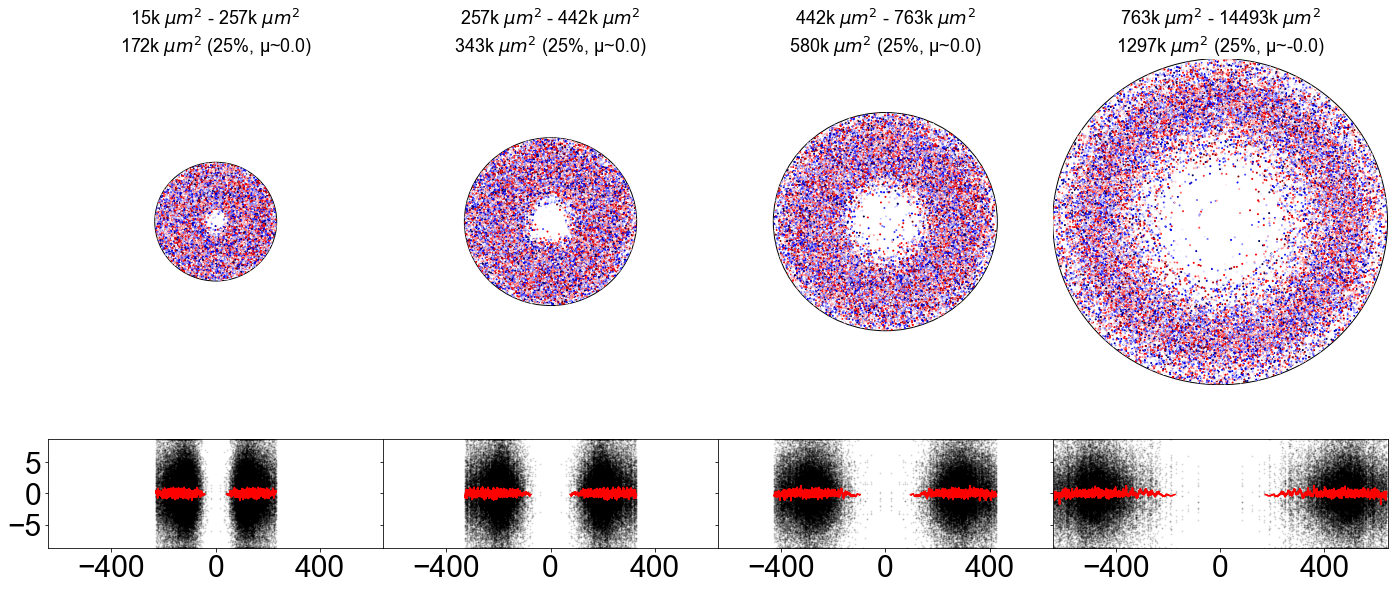

(151958, 1299) Colony diam: [ 93.43769881 173.64578572 326.77245052]
Number of input samples: 202847
Number of used for the plot: 151958
Proportion of samples kept: 74.9%
(151958, 14)
(131791, 14)
Min and max value for colors: -5.953250803238365 5.953250803238365


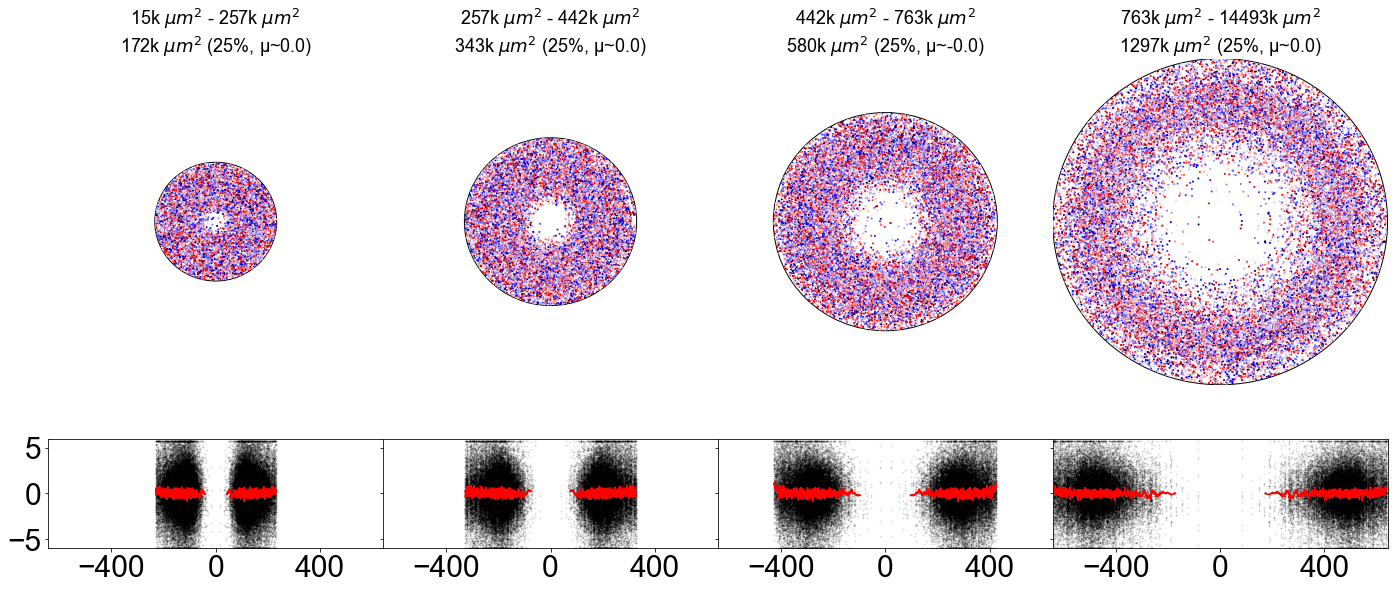

In [28]:
for sm in control.get_shape_modes():
    df_colony, pcts, df_filtered = prepare_dataframe_for_colony_analysis(
        df_input = df,
        cvar = sm,
        unit = 1,
        nbins = 4
    )
    plot_template_colonies(
        df_input = df_colony,
        pcts = pcts,
        cmap = 'seismic',
        force_symmetry = True,
        clip = 1,
        save = f"FigureHeight2_{sm}.png"
    )

In [29]:
acq_order = ["TUBA1B", "TOMM20", "LMNB1", "DSP", "SEC61B", "ACTB", "ST6GAL1", "MYH10", "TJP1", "FBL", "LAMP1", "CETN2", "GJA1", "AAVS1", "ACTN1", "PXN", "NPM1", "CTNNB1", "RAB5A", "SLC25A17", "HIST1H2BJ", "NUP153", "ATP2A2", "SMC1A", "SON"]
[dict([(k, v) for k, v in zip(control.get_gene_names(), control.get_structure_names())])[k] for k in acq_order]

['microtubules',
 'mitochondria',
 'nuclear envelope',
 'desmosomes',
 'ER [Sec61 beta)',
 'actin filaments',
 'Golgi',
 'actomyosin bundles',
 'tight junctions',
 'nucleoli [DFC)',
 'lysosomes',
 'centrioles',
 'gap junctions',
 'plasma membrane',
 'actin bundles',
 'matrix adhesions',
 'nucleoli [GC)',
 'adherens junctions',
 'endosomes',
 'peroxisomes',
 'histones',
 'nuclear pores',
 'ER [SERCA2)',
 'cohesins',
 'nuclear speckles']

In [30]:
common.now("complete")

complete 2022-05-18 14:25:40
